In [ ]:
LSTM을 이용한 삼성전자 주가 예측

In [495]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pandas_datareader.data as pdr

import datetime
from torch.autograd import variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [496]:
# from google.colab import drive
# drive.mount('/content/drive')

In [497]:
#불러올 파일의 경로를 filename 변수에 저장
#filename = 'C:/Users/문서/BTC-USD.csv'
#filename = 'C:/Users/jhshi/Downloads/BTC-USD (1).csv'
#filename = 'C:/Users/jhshi/OneDrive/문서/Python Scripts/BTC.csv'
filename = 'C:/Users/jhshi/Downloads/BTC.csv'
#filename = 'C:/Users/문서/SBUX.csv'
#filename = '/content/SBUX.csv'
df = pd.read_csv(filename)

In [498]:
#pandas read_csv로 불러오기
df = pd.read_csv(filename,index_col ='Date' , parse_dates = True)
df.columns
#df = pd.read_csv(filename, index_col = ‘Date’, parse_dates=True)

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [499]:
df.head()
df.shape

(366, 6)

In [500]:
# start = (2000, 1, 1) # 2020년 01년 01월 
# start = datetime.datetime(*start) 
# end = datetime.date.today() # 현재 
# # yahoo 에서 삼성 전자 불러오기 
# #df = pdr.DataReader('005930.KS', 'yahoo', start, end) 
# df.head(5) 
# df.tail(5) 
# df.Close.plot(grid=True)

#plt.style.use(‘ggplot’)
#df[‘Volume’].plot(label=‘CLOSE’, title=‘**** Stock Volume’)

In [501]:
X = df.iloc[:, :-1]
y = df.iloc[:, 5:6] 
#print(X) 
#print(y)

# open 시가
# high 고가 
# low 저가
# close 종가
# voulume 거래량
# Adj close 주식의 분할, 배당, 배분 등을 고려해 조정한 종가

# 확실한건 거래량 은 데이터에서 제하는것이 중요하다.


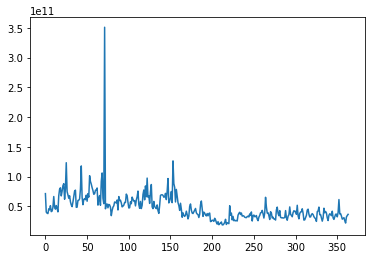

In [502]:
y_n = np.array(y)
# #print(y_n.T)
len(y_n)
x_n= list(range(len(y_n)))
# #print(x_n)
import matplotlib.pyplot as plt
plt.plot(x_n,y_n)
plt.show()
# print(len(y_n))

In [503]:
# 학습이 잘되기 위해 데이터 정규화
# StandardScaler 각 특징의 평균을 0, 분산을 1이 되도록 변경
# MinMax Scaler  최대 / 최소 값이 각각 1, 0 이 되도록 변경
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()


X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y) 

In [504]:
#first 200 for training

X_train = X_ss[:330, :]
X_test = X_ss[330:, :]

print(X_train.shape)
print(X_test.shape)
y_train = y_mm[:330, :]
y_test = y_mm[330:, :] 

(330, 5)
(36, 5)


In [505]:
print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape (330, 5) (330, 1)
Testing Shape (36, 5) (36, 1)


In [506]:
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable 

In [507]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

print(X_train_tensors.shape)
y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test)) 

torch.Size([330, 5])


In [508]:
#reshaping to rows, timestamps, features

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))


X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

In [509]:
print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape torch.Size([330, 1, 5]) torch.Size([330, 1])
Testing Shape torch.Size([36, 1, 5]) torch.Size([36, 1])


In [510]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [511]:

num_epochs = 1000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 5 #number of features
hidden_size = 1 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

In [512]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) #our lstm class 

In [513]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate) 

In [514]:
for epoch in range(num_epochs):
  outputs = lstm1.forward(X_train_tensors_final) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
  # obtain the loss function
  loss = criterion(outputs, y_train_tensors)
 
  loss.backward() #calculates the loss of the loss function
 
  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: 0.00880
Epoch: 100, loss: 0.00569
Epoch: 200, loss: 0.00561
Epoch: 300, loss: 0.00555
Epoch: 400, loss: 0.00550
Epoch: 500, loss: 0.00546
Epoch: 600, loss: 0.00543
Epoch: 700, loss: 0.00541
Epoch: 800, loss: 0.00539
Epoch: 900, loss: 0.00538


In [516]:
df_X_ss = ss.transform(df.iloc[:, :-1]) #old transformers
df_y_mm = mm.transform(df.iloc[:, -1:]) #old transformers

df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1])) 

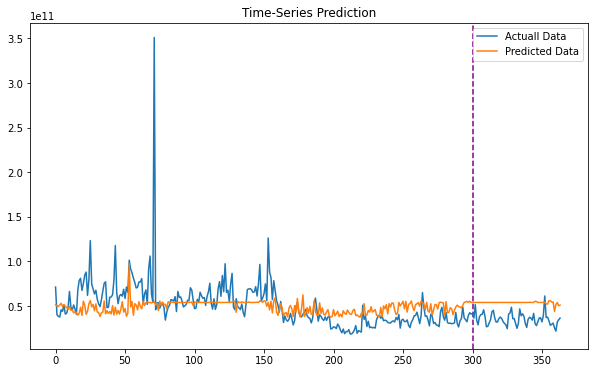

In [517]:
train_predict = lstm1(df_X_ss)#forward pass
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=300, c='purple', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 